## Predict future values based on previously observed values

In [8]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings. filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [9]:
df = pd.read_excel("Superstore.xls")
df = df.loc[df['Category']=='Furniture']

In [10]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [4]:
df['Order Date'].min(), df['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

### Data Preprocessing

In [5]:
#removing columns we do not need, checking missing values, 
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Order Date')
df.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [11]:
df = df.groupby('Order Date')['Sales'].sum().reset_index()


In [12]:
# Indexing with Time Series Data
df = df.set_index('Order Date')
df.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [16]:
# utilizing averages daily sales value for that month 
# utilizing start of each month 
y = df['Sales'].resample('MS').mean()


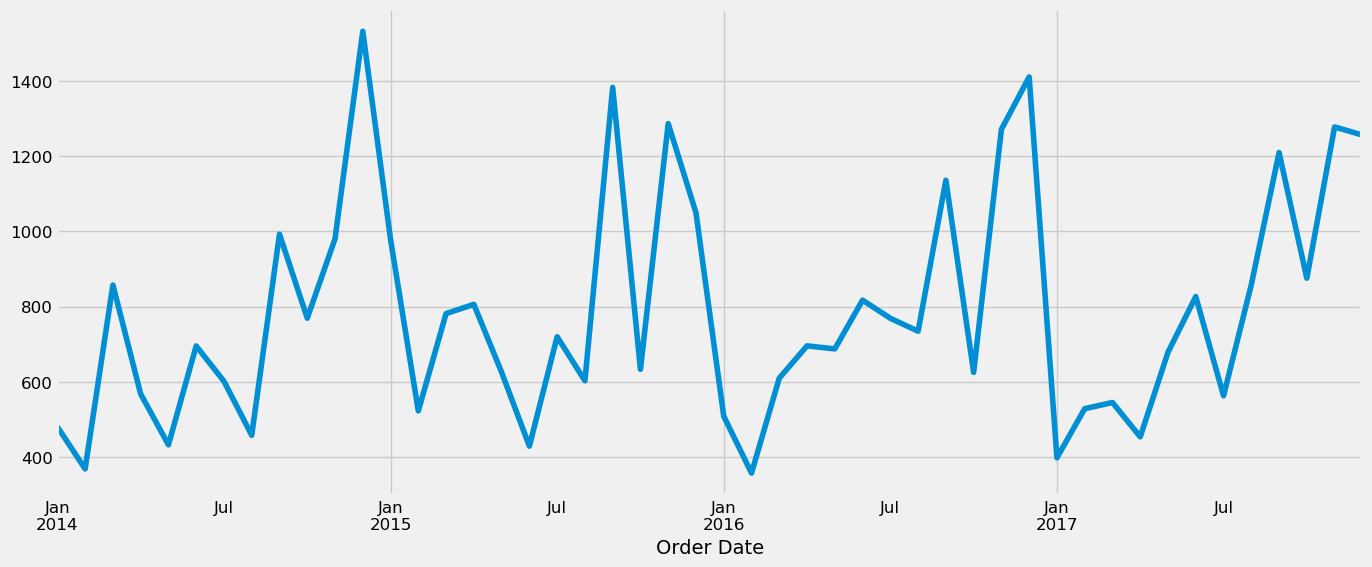

In [17]:
y.plot(figsize=(15, 6))
plt.show()

we can see that sales are low at the beginning of the year. upward trend toward the end of the year

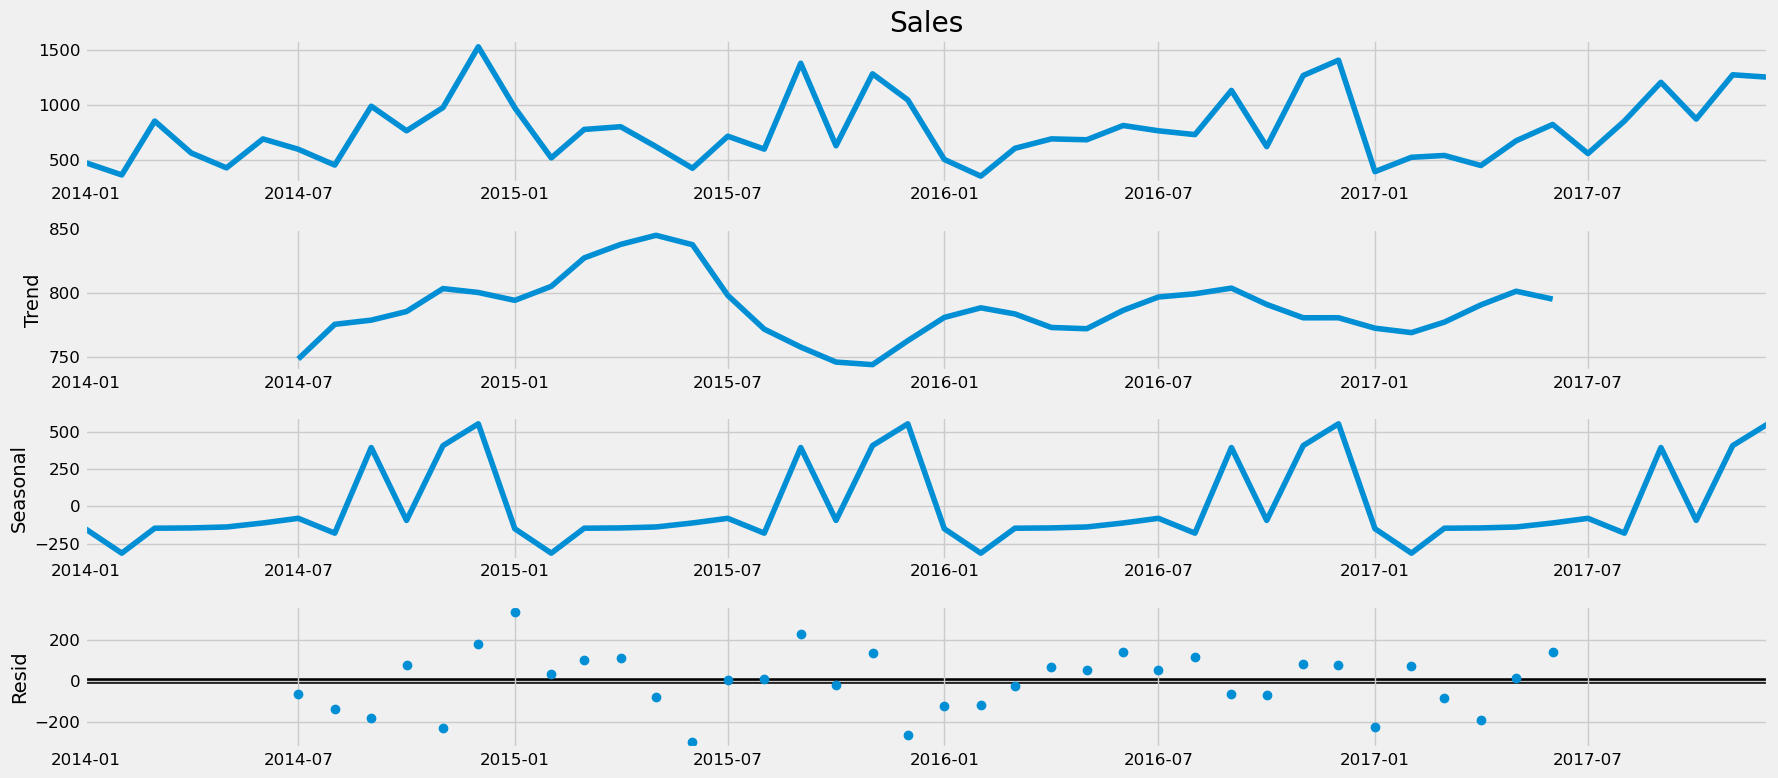

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Only thing that exist is there are patterns in the season

## Time series forecasting with ARIMA

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [32]:
best_aic = float("inf")
best_param = None
best_param_seasonal = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_param_seasonal = param_seasonal
                
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
# Print the best model and its AIC
print('Best Model: ARIMA{}x{}12 - AIC:{}'.format(best_param, best_param_seasonal, best_aic))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99048D+00    |proj g|=  1.66962D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   2.398D-07   7.990D+00
  F =   7.9904349200061615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variable

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.57422D+00    |proj g|=  2.93923D-02

At iterate   15    f=  7.55111D+00    |proj g|=  2.39326D-01

At iterate   20    f=  7.46798D+00    |proj g|=  2.90535D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     27      1     0     0   5.018D-08   7.468D+00
  F =   7.4679711153730155     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.23796D+00    |proj g|=  5.22719D-01

At iterate   25    f=  5.18502D+00    |proj g|=  1.92847D-01

At iterate   30    f=  5.16011D+00    |proj g|=  5.55692D-02

At iterate   35    f=  5.14991D+00    |proj g|=  4.35656D-03

At iterate   40    f=  5.14548D+00    |proj g|=  4.55540D-03

At iterate   45    f=  5.14304D+00    |proj g|=  3.08832D-03

At iterate   50    f=  5.14118D+00    |proj g|=  2.58315D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     71      1     0     0   2.583D-03   5.141D+00
  F =   5.1411830589893945     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   1.068D-06   3.271D+00
  F =   3.2707134134863209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946868
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03608D+00    |proj g|=  1.53380D-01

At iterate    5    f=  3.01570D+00    |proj g|=  2.21140D-02

At iterate   10    f=  3.01390D+00    |proj g|=  1.40285D-03

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This probl

  ys=-9.754E+01  -gs= 7.033E-01 BFGS update SKIPPED
  ys=-8.237E+00  -gs= 6.363E-01 BFGS update SKIPPED

At iterate    5    f=  1.22191D+01    |proj g|=  3.46670D+05
  ys=-1.779E-01  -gs= 1.774E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6    103      2     3     0   3.467D+05   1.222D+01
  F =   12.219059583775978     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1177.0297200424939
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exac

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  6.73017D+00    |proj g|=  3.26868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     23      1     0     0   1.285D-05   6.728D+00
  F =   6.7281835175176781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176816971
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71350D+01    |proj g|=  7.20152D-03
  ys=-5.301E+02  -gs= 3.734E-02 BFGS update SKIPPED
  ys=-1.468E+01  -gs= 9.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.92864D+00    |proj g|=  5.96714D-03

At iterate   15    f=  2.92143D+00    |proj g|=  7.46461D-02

At iterate   20    f=  2.87919D+00    |proj g|=  1.99189D-02

At iterate   25    f=  2.85662D+00    |proj g|=  4.00633D-02

At iterate   30    f=  2.84985D+00    |proj g|=  3.98999D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     43      1     0     0   8.522D-06   2.850D+00
  F =   2.8497981597780466     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:279.5806233386925
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.93137D+00    |proj g|=  4.51405D-02

At iterate   10    f=  2.92843D+00    |proj g|=  1.02500D-03

At iterate   15    f=  2.92822D+00    |proj g|=  2.90988D-02

At iterate   20    f=  2.89347D+00    |proj g|=  2.64524D-01

At iterate   25    f=  2.85822D+00    |proj g|=  2.18981D-01

At iterate   30    f=  2.84956D+00    |proj g|=  8.30523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     45      1     0     0   6.303D-06   2.850D+00
  F =   2.8495589806887991     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:281.5576621461

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   25    f=  4.94715D+00    |proj g|=  1.23993D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     30      1     0     0   5.008D-07   4.947D+00
  F =   4.9471451749325093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935209
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75897D+01    |proj g|=  1.92423D-03

At iterate    5    f=  2.75353D+01    |proj g|=  1.06944D-02
  ys=-4.360E+01

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


  ys=-1.653E+04  -gs= 2.971E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     82      3     1     0   8.037D+04   2.614D+01
  F =   26.143708627311327     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2517.7960282218874
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82203D+00    |proj g|=  9.77386D-02

At iterate    5    f=  4.81853D+00    |proj g|=  1.78050D-02
ARIMA(1, 0, 1)x(0, 1, 0,

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:293.34221939659733
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11566D+00    |proj g|=  2.79617D-01

At iterate    5    f=  5.04734D+00    |proj g|=  1.37385D-02

At iterate   10    f=  5.04246D+00    |proj g|=  2.25429D-03

At iterate   15    f=  5.04233D+00    |proj g|=  1.07594D-02

At iterate   20    f=  5.02608D+00    |proj g|=  1.61370D-01

At iterate   25    f=  4.94416D+00    |proj g|=  2.94016D-02

At iterate   30    f=  4.94350D+00    |proj g|=  2.63540D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      4     63      2     0     0   3.718D+03   2.597D+01
  F =   25.974990583151051     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2503.599095982501
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15364D+00    |proj g|=  6.09532D-02

At iterate    5    f=  3.14852D+00    |proj g|=  6.15364D-03

At iterate   10    f=  3.14679D+00    |proj g|=  2.38065D-02

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.654E+01  -gs= 6.905E-01 BFGS update SKIPPED
  ys=-2.662E+02  -gs= 7.065E-01 BFGS update SKIPPED

At iterate    5    f=          NaN    |proj g|=          NaN
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:nan

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     83      2     3     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10197D+00    |proj g|= 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.62709013454435
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12416D+00    |proj g|=  1.59332D-01

At iterate    5    f=  3.09966D+00    |proj g|=  1.44150D-02

At iterate   10    f=  3.09925D+00    |proj g|=  2.70335D-03

At iterate   15    f=  3.09397D+00    |proj g|=  5.42312D-02

At iterate   20    f=  3.06825D+00    |proj g|=  1.66853D-02

At iterate   25    f=  3.06621D+00    |proj g|=  1.00832D-02

At iterate   30    f=  3.06590D+00    |proj g|=  1.38759D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.280E+07  -gs= 5.189E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     29      2     1     0   2.073D+06   6.476D+00
  F =   6.4759173481233780     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:629.6880654198443
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77247D+00    |proj g|=  5.57251D-02

At iterate    5    f=  4.74738D+00    |proj g|=  7.45904D-02

At iterate   10    f=  4

 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      2     28      2     1     0   8.547D+05   1.905D+01
  F =   19.049925960486316     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1838.7928922066862
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09103D+00    |proj g|=  3.72719D-02

At iterate    5    f=  3.08056D+00    |proj g|=  3.47745D-02

At iterate   10    f=  3.07783D+00    |proj g|=  1.16849D-03
  ys=-2.589E-0

 This problem is unconstrained.


In [33]:
## Fitting the ARIMA model

In [34]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09103D+00    |proj g|=  3.72719D-02

At iterate    5    f=  3.08056D+00    |proj g|=  3.47745D-02

At iterate   10    f=  3.07783D+00    |proj g|=  1.16849D-03
  ys=-2.589E-04  -gs= 2.696E-04 BFGS update SKIPPED

At iterate   15    f=  3.07434D+00    |proj g|=  9.55769D-04

At iterate   20    f=  3.07399D+00    |proj g|=  2.28254D-02

At iterate   25    f=  3.04255D+00    |proj g|=  2.03783D-01

At iterate   30    f=  3.01863D+00    |proj g|=  1.36640D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.


### plot diagnostics

### Validating forecast

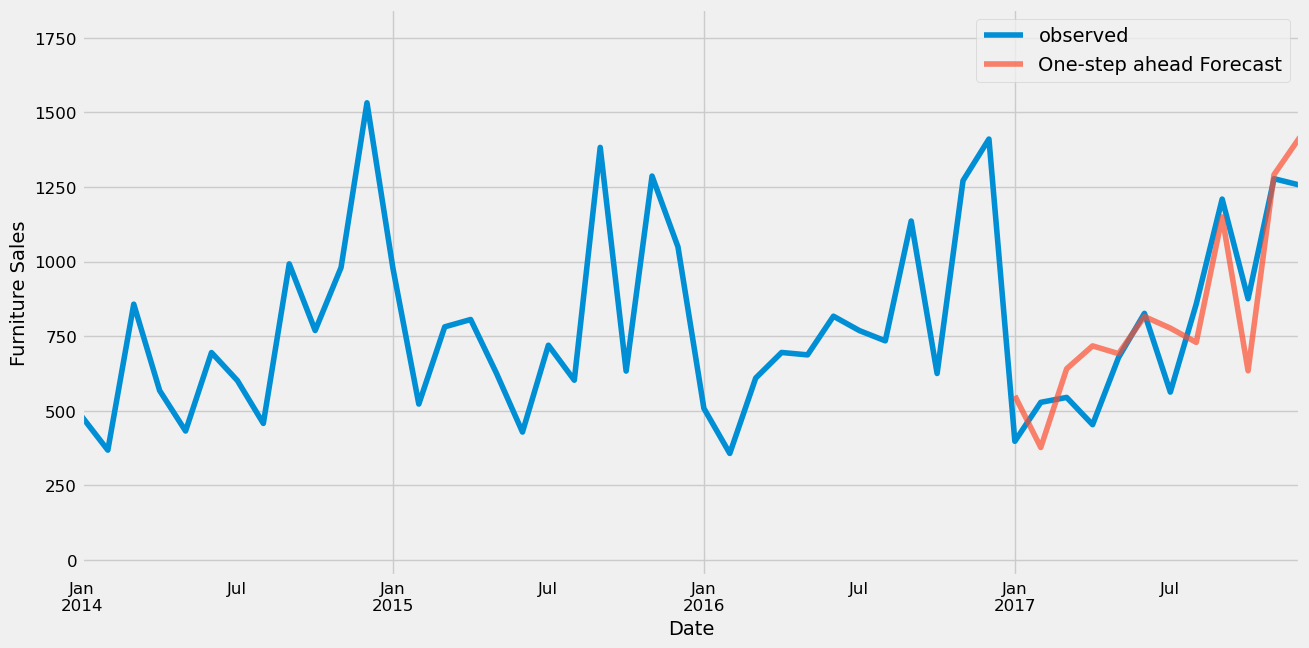

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [46]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 22993.56


In [47]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


this RMSE show the model was able to forecast the average daily furniture sales in the test set within 151.64 of real sales, which is really good

### producing a visualizing forecast

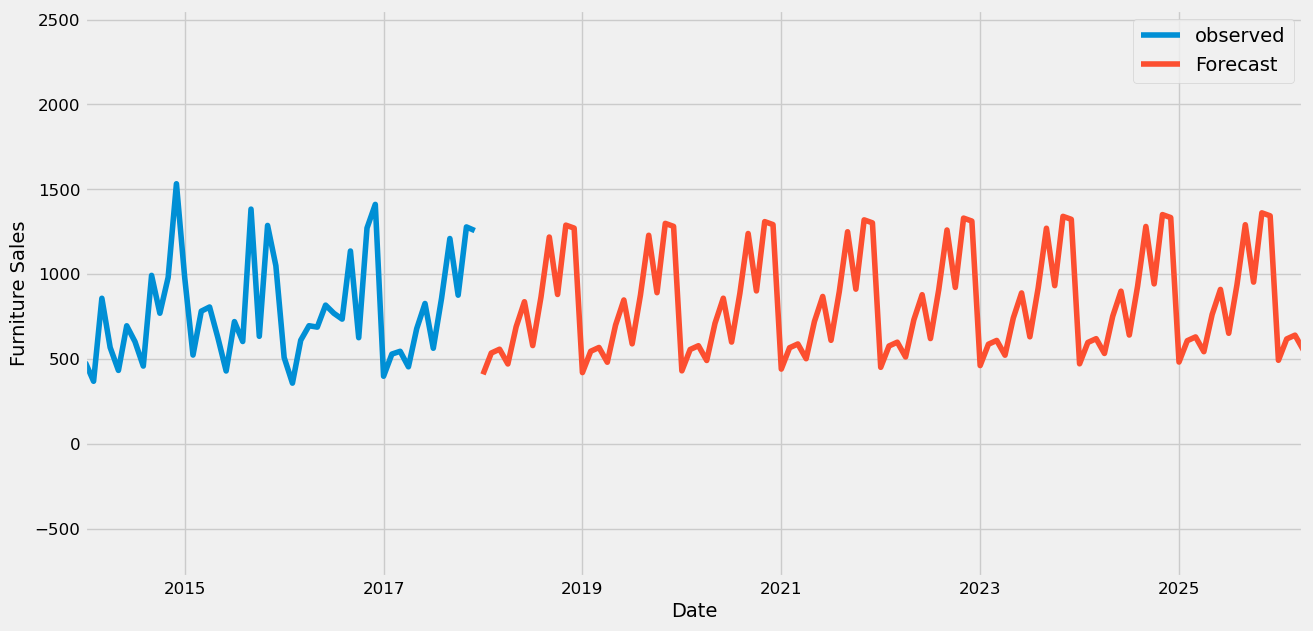

In [49]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Time series fo furniture vs office supplies

In [52]:
df

,Sales
Order Date,
2014-01-06,2573.8200
2014-01-07,76.7280
2014-01-10,51.9400
2014-01-11,9.9400
2014-01-13,879.9390
...,...
2017-12-24,1393.4940
2017-12-25,832.4540
2017-12-28,551.2568


.. to be continue